In [ ]:
# preprocessing code for the entire dataset from Hiba (section labeled 'All data'), all other code from Hsinyen
import numpy as np
import scanpy as sc
from scipy import io
import pandas as pd
import skmisc
import palantir
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# All data

In [ ]:
base = "GSE211644"

# read matrix and metadata
mat = io.mmread(f"{base}/GSE211644_fresh_matrix.mtx.gz").T.tocsr() # transpose and make sparse for efficient storage
genes = pd.read_csv(f"{base}/GSE211644_fresh_genes.tsv.gz", sep="\t", header=None)
barcodes = pd.read_csv(f"{base}/GSE211644_fresh_barcodes.tsv.gz", sep="\t", header=None)
metadata = pd.read_csv(f"{base}/GSE211644_fresh_metadata.csv.gz", index_col=0)

# make AnnData object
adata = sc.AnnData(X=mat) # cell x gene matrix
adata.obs_names = barcodes.iloc[:, 0].astype(str).values # cells
adata.var_names = genes.iloc[:, 0].astype(str).values # genes

# add metadata to adata.obs
adata.obs = adata.obs.join(metadata)

# make mda2 subset of adata
barcodes = pd.Index(adata.obs_names)
mda2_mask = barcodes.str.startswith('MDA2_')
m2_adata = adata[mda2_mask].copy()

# MDA 1 analysis

In [ ]:
# make mda1 subset of adata
barcodes = pd.Index(adata.obs_names)
mda1_mask = barcodes.str.startswith('MDA1_')
adata = adata[mda1_mask].copy()

In [ ]:
# annotate sample type
sample_codes = pd.Series(adata.obs_names).str.split('_', expand=True)[1]
adata.obs['sample_type'] = np.where(
    sample_codes.str.startswith('T'),
    'tumor',
    'uninvolved'
)

In [ ]:
# check sample type counts
adata.obs['sample_type'].value_counts()

sample_type
tumor         2637
uninvolved     508
Name: count, dtype: int64

In [ ]:
# set seed
rng = 123

# layer
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# filter for highly variable genes
sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, flavor="seurat_v3", layer="counts"
)
adata_hvg = adata[:, adata.var['highly_variable']].copy()
sc.pp.scale(adata_hvg, max_value=10)
sc.tl.pca(adata_hvg, n_comps=50, svd_solver="arpack")
sc.pp.neighbors(adata_hvg, n_neighbors=15, n_pcs=30, random_state=rng)
sc.tl.umap(adata_hvg, random_state=rng)

/opt/homebrew/Cellar/python@3.13/3.13.9_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


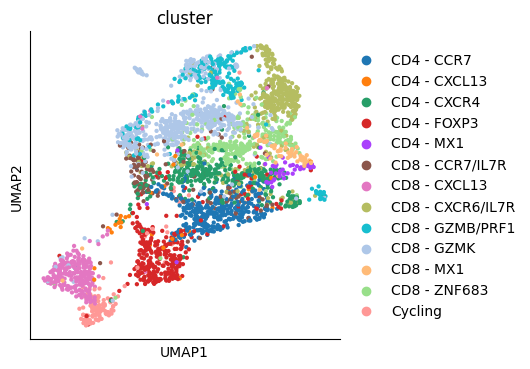

In [ ]:
# visualize clusters
sc.pl.umap(adata_hvg, color='cluster')

In [ ]:
# separate into cd4 and cd8 - use the original adata with counts
adata_cd4 = adata[adata.obs['cluster'].str.startswith('CD4'), :].copy()
adata_cd8 = adata[adata.obs['cluster'].str.startswith('CD8'), :].copy()

# MDA1 CD4 pseudotime and trajectory inference

/Users/hsinyenhuang/Documents/genomics_project/.venv/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/opt/homebrew/Cellar/python@3.13/3.13.9_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


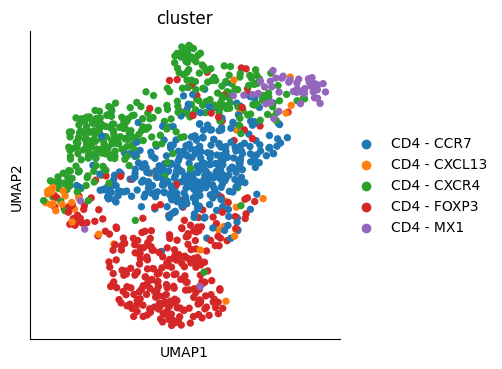

In [ ]:
# preprocess cd4 data from scratch
adata_cd4.layers["counts"] = adata_cd4.X.copy()
sc.pp.normalize_total(adata_cd4, target_sum=1e4)
sc.pp.log1p(adata_cd4)
sc.pp.highly_variable_genes(adata_cd4, n_top_genes=2000, flavor="seurat_v3", layer="counts")
adata_cd4 = adata_cd4[:, adata_cd4.var['highly_variable']].copy()
sc.pp.scale(adata_cd4, max_value=10)
sc.tl.pca(adata_cd4, n_comps=50, svd_solver="arpack")
sc.pp.neighbors(adata_cd4, n_neighbors=15, n_pcs=30, random_state=rng)
sc.tl.umap(adata_cd4, random_state=rng)
sc.pl.umap(adata_cd4, color='cluster')

In [ ]:
# calculate diffusion maps, multiscale space, and magic imputation for mda1 cd4 data
dm_res = palantir.utils.run_diffusion_maps(adata_cd4, n_components=50)
ms_data = palantir.utils.determine_multiscale_space(adata_cd4)
imputed_X = palantir.utils.run_magic_imputation(adata_cd4)

In [ ]:
# Find cell with CCR7 expression near upper quartile
naive = adata_cd4[adata_cd4.obs['cluster'] == 'CD4 - CCR7']
ccr7_expr = naive[:, 'CCR7'].X.toarray().flatten()
q75 = np.percentile(ccr7_expr, 75)

# Find cell closest to 75th percentile (to avoid outliers)
target_value = q75
closest_idx = np.argmin(np.abs(ccr7_expr - target_value))
root_cell = naive.obs_names[closest_idx]

print(f"Selected root cell: {root_cell}")
print(f"Root cell cluster: {adata_cd4.obs.loc[root_cell, 'cluster']}")
print(f"Root cell CCR7 expression: {ccr7_expr[closest_idx]:.3f}")

Selected root cell: MDA1_T04_CAGAATCTCATCACCC
Root cell cluster: CD4 - CCR7
Root cell CCR7 expression: 1.849


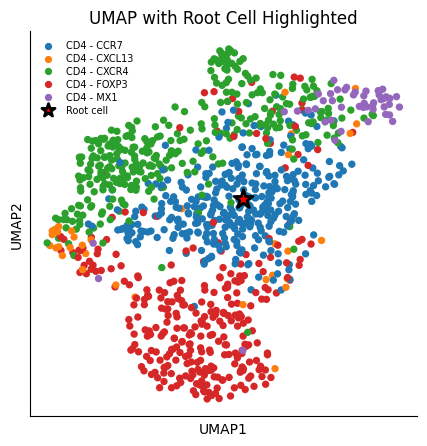

In [ ]:
# plot umap with root cell highlighted
fig, ax = plt.subplots(figsize=(5, 5))

sc.pl.umap(adata_cd4, color=['cluster'],ax=ax, show=False, cmap='viridis')

umap_coords = adata_cd4.obsm['X_umap']

root_idx = adata_cd4.obs.index.get_loc(root_cell)
root_x, root_y = umap_coords[root_idx]

ax.scatter(root_x, root_y, c='red', s=200, marker='*', edgecolors='black', linewidths=2, 
           label=f'Root cell', zorder=10)

ax.legend(loc="best", fontsize=7, markerscale=0.7, frameon=False, labelspacing=0.3)
ax.set_title('UMAP with Root Cell Highlighted')
plt.show()

In [ ]:
# Get unique clusters excluding CD4 - CCR7
clusters_to_find = adata_cd4.obs['cluster'][adata_cd4.obs['cluster'] != 'CD4 - CCR7'].unique()

# Find terminal states for each cluster
terminal_cells = palantir.utils.find_terminal_states(
    adata_cd4, 
    celltypes=clusters_to_find,
    celltype_column='cluster'
)

Using MDA1_T01_CTAGCCTGTAAGAGGA for cell type CD4 - FOXP3 which is min in diffusion component 0.
Using MDA1_T05_CAACTAGAGATGGGTC for cell type CD4 - CXCL13 which is min in diffusion component 6.
Using MDA1_T03_CGGGTCACAAGGTTCT for cell type CD4 - CXCR4 which is max in diffusion component 1.
Using MDA1_T01_AGGCCGTTCCACTCCA for cell type CD4 - MX1 which is max in diffusion component 3.


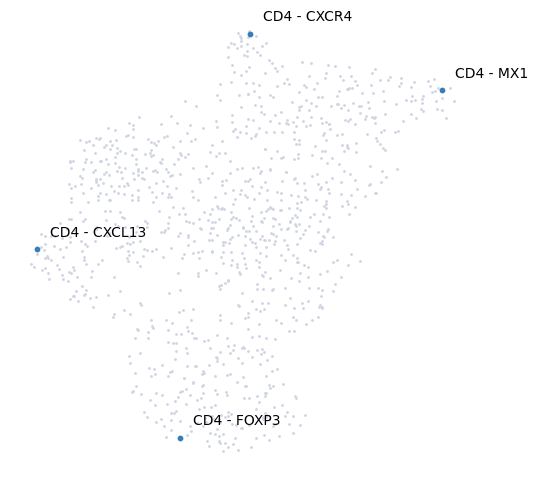

In [ ]:
# plot umap with terminal cells highlighted
palantir.plot.highlight_cells_on_umap(adata_cd4, terminal_cells)
plt.show()

In [ ]:
# run palantir
pr_res = palantir.core.run_palantir(
    adata_cd4, root_cell, num_waypoints=500, terminal_states=terminal_cells
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.00021683772404988607 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.044427581628163654 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.8025
Correlation at iteration 2: 0.9988
Correlation at iteration 3: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


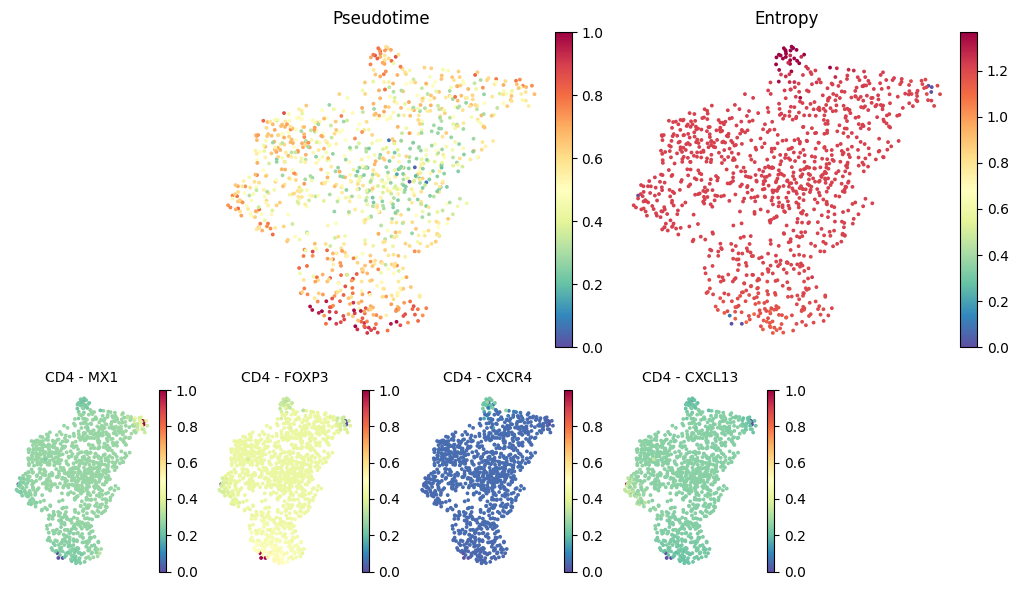

In [ ]:
# plot palantir results
palantir.plot.plot_palantir_results(adata_cd4, s=3)
plt.show()

In [ ]:
# select for cells belonging to specific branches
masks = palantir.presults.select_branch_cells(adata_cd4, q=.01, eps=.01)

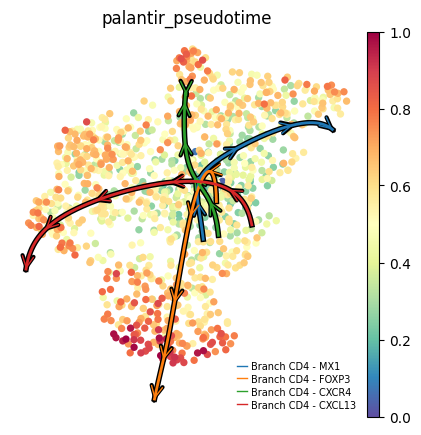

In [ ]:
# plot trajectories
palantir.plot.plot_trajectories(
    adata_cd4,
    legend_kwargs=dict(
        fontsize=7,
        frameon=False,
        handlelength=1.0,
        labelspacing=0.3,
        handletextpad=0.4,
        borderpad=0.2,
        loc="lower right",          # pick a corner
        bbox_to_anchor=(1.0, 0.0),  # nudge if needed
    ),
)
plt.show()


<Axes: >

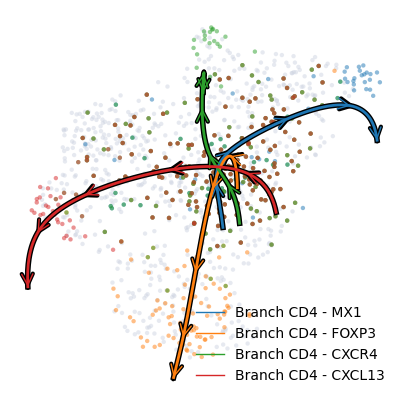

In [ ]:
palantir.plot.plot_trajectories(adata_cd4, cell_color = "branch_selection", pseudotime_interval=(0, .9))

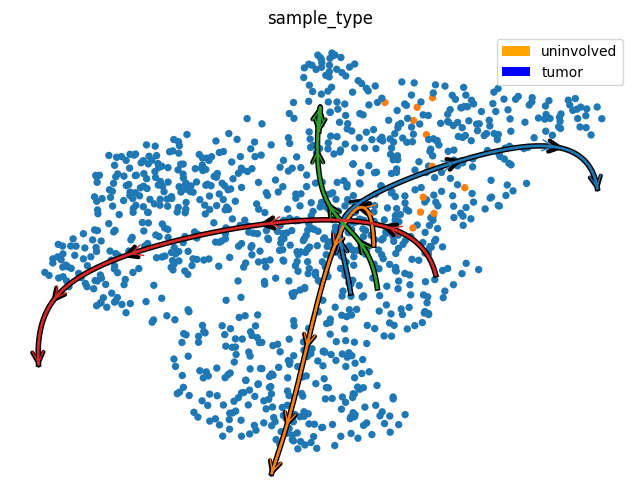

In [ ]:
# umap and trajectories colored by sample type
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(8, 6))
palantir.plot.plot_trajectories(adata_cd4, cell_color="sample_type", pseudotime_interval=(0, .9), ax=ax)

handles, labels = ax.get_legend_handles_labels()

# filter to keep only the branch trajectory lines
branch_handles = [(h, l) for h, l in zip(handles, labels) if l.startswith('Branch')]

sample_type_handles = [
    (Patch(facecolor='orange'), 'uninvolved'),
    (Patch(facecolor='blue'), 'tumor')
]

all_items = branch_handles + sample_type_handles
all_handles = [h for h, l in all_items]
all_labels = [l for h, l in all_items]

ax.legend(all_handles, all_labels, loc='best')
plt.show()

# MDA1 CD8 pseudotime and trajectory inference

/Users/hsinyenhuang/Documents/genomics_project/.venv/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/opt/homebrew/Cellar/python@3.13/3.13.9_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


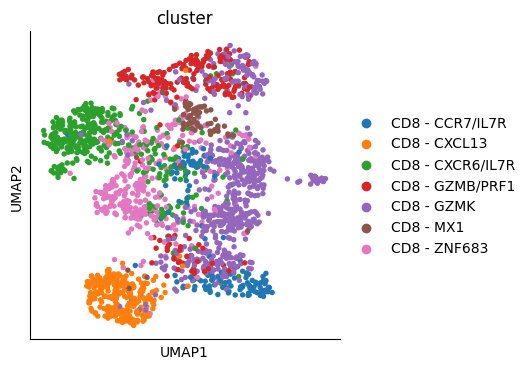

In [ ]:
# preprocess cd8 data from scratch
adata_cd8.layers["counts"] = adata_cd8.X.copy()
sc.pp.normalize_total(adata_cd8, target_sum=1e4)
sc.pp.log1p(adata_cd8)
sc.pp.highly_variable_genes(adata_cd8, n_top_genes=2000, flavor="seurat_v3", layer="counts")
adata_cd8 = adata_cd8[:, adata_cd8.var['highly_variable']].copy()
sc.pp.scale(adata_cd8, max_value=10)
sc.tl.pca(adata_cd8, n_comps=50, svd_solver="arpack")
sc.pp.neighbors(adata_cd8, n_neighbors=15, n_pcs=30, random_state=rng)
sc.tl.umap(adata_cd8, random_state=rng)
sc.pl.umap(adata_cd8, color='cluster')

In [ ]:
# calculate diffusion maps, multiscale space, and magic imputation for mda1 cd8 data
dm_res = palantir.utils.run_diffusion_maps(adata_cd8, n_components=50)
ms_data = palantir.utils.determine_multiscale_space(adata_cd8)
imputed_X = palantir.utils.run_magic_imputation(adata_cd8)

In [ ]:
# Find cell with IL7R expression near upper quartile
naive = adata_cd8[adata_cd8.obs['cluster'] == 'CD8 - CCR7/IL7R']
il7r_expr = naive[:, 'IL7R'].X.toarray().flatten()
q75 = np.percentile(il7r_expr, 75)

# Find cell closest to 75th percentile (to avoid outliers)
target_value = q75
closest_idx = np.argmin(np.abs(il7r_expr - target_value))
root_cell = naive.obs_names[closest_idx]

print(f"Selected root cell: {root_cell}")
print(f"Root cell cluster: {adata_cd8.obs.loc[root_cell, 'cluster']}")
print(f"Root cell IL7R expression: {il7r_expr[closest_idx]:.3f}")

Selected root cell: MDA1_T05_ACATACGCATCCCATC
Root cell cluster: CD8 - CCR7/IL7R
Root cell IL7R expression: 1.371


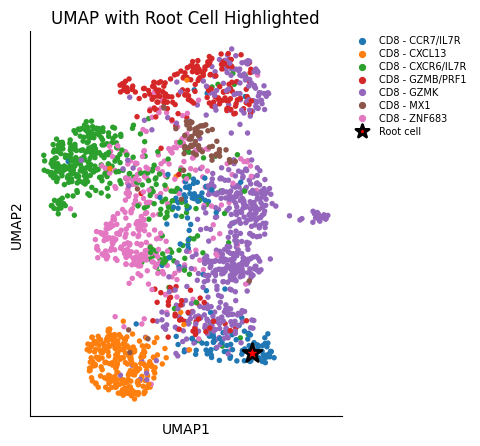

In [ ]:
# plot umap with root cell highlighted
fig, ax = plt.subplots(figsize=(5, 5))

sc.pl.umap(adata_cd8, color=['cluster'], ax=ax, show=False, cmap='viridis')

umap_coords = adata_cd8.obsm['X_umap']
root_idx = adata_cd8.obs.index.get_loc(root_cell)
root_x, root_y = umap_coords[root_idx]

ax.scatter(root_x, root_y, c='red', s=200, marker='*', edgecolors='black',
           linewidths=2, label='Root cell', zorder=10)

ax.legend(
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0), 
    fontsize=7,
    markerscale=0.7,
    frameon=False,
    labelspacing=0.3,
    borderaxespad=0.0,
)

ax.set_title("UMAP with Root Cell Highlighted")

fig.subplots_adjust(right=0.75)

plt.show()


In [ ]:
# get unique clusters excluding CD8 - CCR7/IL7R
clusters_to_find = adata_cd8.obs['cluster'][adata_cd8.obs['cluster'] != 'CD8 - CCR7/IL7R'].unique()

# find terminal states for each cluster
terminal_cells = palantir.utils.find_terminal_states(
    adata_cd8, 
    celltypes=clusters_to_find,
    celltype_column='cluster'
)

Using MDA1_T05_AAGGTTCTCGAGGTAG for cell type CD8 - CXCL13 which is min in diffusion component 2.
Using MDA1_T07_TACGGATCAGCTCCGA for cell type CD8 - ZNF683 which is min in diffusion component 6.
Using MDA1_U05_TTGAACGGTGTCCTCT for cell type CD8 - CXCR6/IL7R which is max in diffusion component 1.
Using MDA1_T03_GGAACTTCAATGGAGC for cell type CD8 - GZMB/PRF1 which is min in diffusion component 0.
Using MDA1_T04_CTTAACTGTCCAACTA for cell type CD8 - GZMK which is max in diffusion component 2.
Using MDA1_T01_ATCCACCGTGAACCTT for cell type CD8 - MX1 which is max in diffusion component 3.


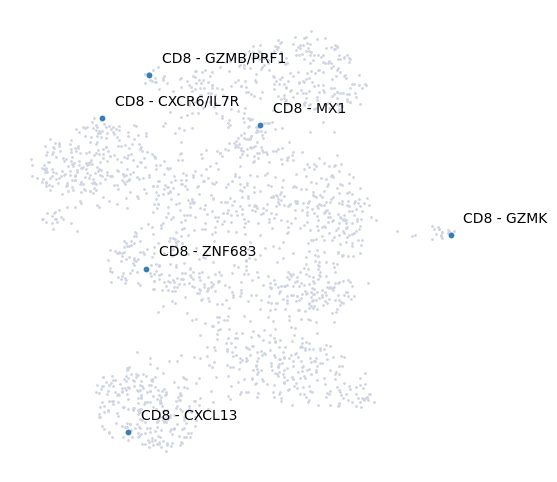

In [ ]:
# plot umap with terminal cells highlighted
palantir.plot.highlight_cells_on_umap(adata_cd8, terminal_cells)
plt.show()

In [ ]:
# run palantir
pr_res = palantir.core.run_palantir(
    adata_cd8, root_cell, num_waypoints=500, terminal_states=terminal_cells
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.00036968787511189777 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.0470988670984904 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9943
Correlation at iteration 2: 0.9997
Correlation at iteration 3: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


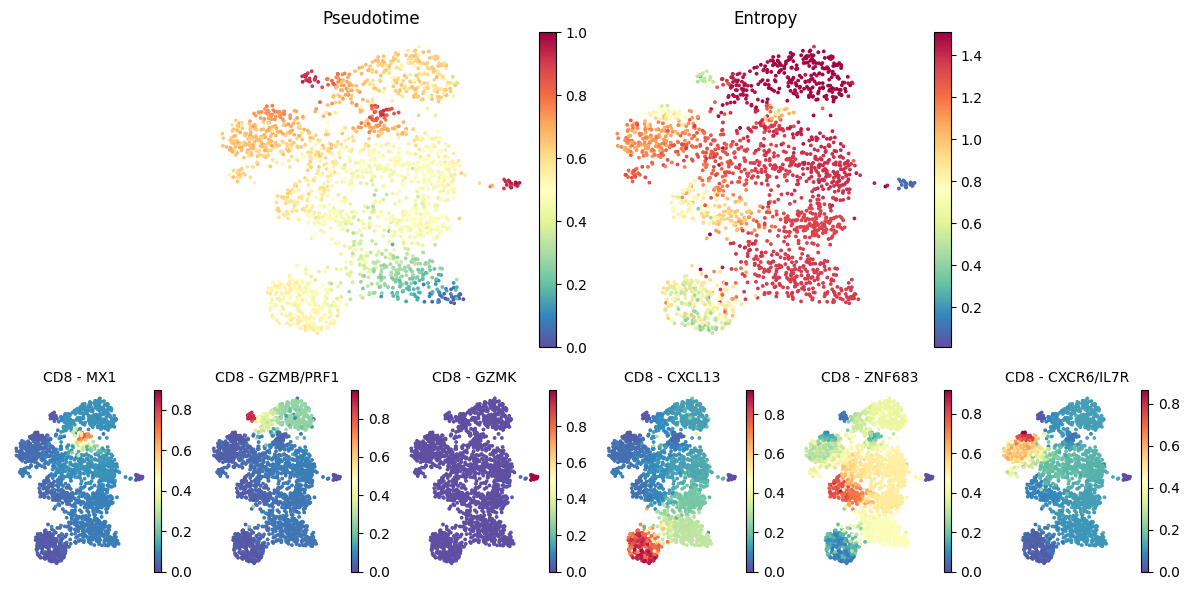

In [ ]:
# plot palantir results
palantir.plot.plot_palantir_results(adata_cd8, s=3)
plt.show()

In [ ]:
# select for cells belonging to specific branches
masks = palantir.presults.select_branch_cells(adata_cd8, q=.01, eps=.01)

<Axes: title={'center': 'palantir_pseudotime'}, xlabel='UMAP1', ylabel='UMAP2'>

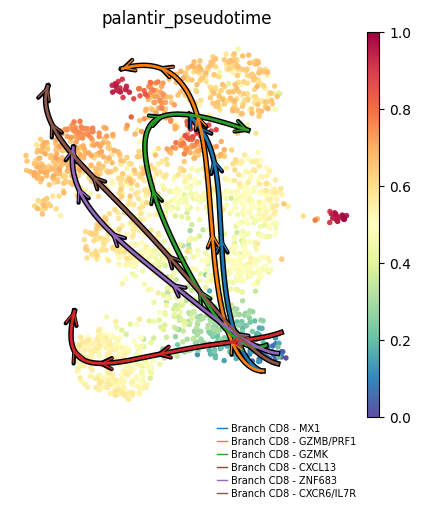

In [ ]:
# plot trajectories
palantir.plot.plot_trajectories(adata_cd8, pseudotime_interval=(0, 1.0), legend_kwargs=dict(
        fontsize=7,
        frameon=False,
        handlelength=1.0,
        labelspacing=0.3,
        handletextpad=0.4,
        borderpad=0.2,
        loc="upper right",          # pick a corner
        bbox_to_anchor=(1.0, 0.0),  # nudge if needed
    ),)

<Axes: >

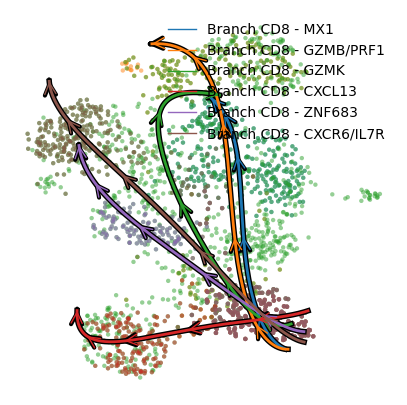

In [ ]:
# trajectories colored by cells belonging to specific branches
palantir.plot.plot_trajectories(adata_cd8, cell_color = "branch_selection", pseudotime_interval=(0, .9))

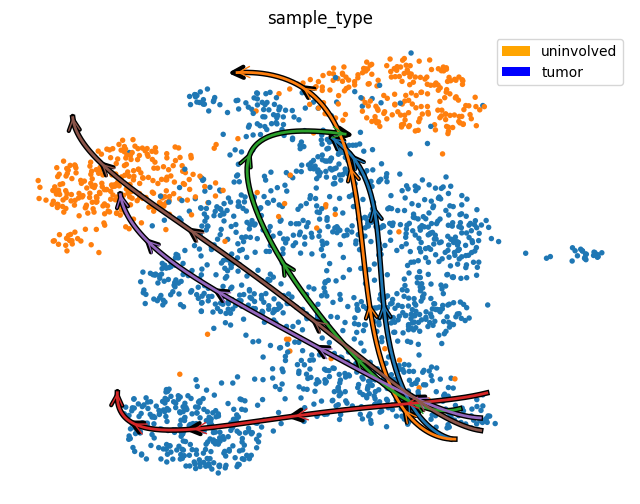

In [ ]:
# umap and trajectories colored by sample type
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(8, 6))
palantir.plot.plot_trajectories(adata_cd8, cell_color="sample_type", pseudotime_interval=(0, .9), ax=ax)

handles, labels = ax.get_legend_handles_labels()

branch_handles = [(h, l) for h, l in zip(handles, labels) if l.startswith('Branch')]

sample_type_handles = [
    (Patch(facecolor='orange'), 'uninvolved'),
    (Patch(facecolor='blue'), 'tumor')
]

all_items = branch_handles + sample_type_handles
all_handles = [h for h, l in all_items]
all_labels = [l for h, l in all_items]

ax.legend(all_handles, all_labels, loc='best')
plt.show()

# MDA2 analysis

In [ ]:
# annotate sample type for mda2
sample_codes = pd.Series(m2_adata.obs_names).str.split('_', expand=True)[1]
m2_adata.obs['sample_type'] = np.where(
    sample_codes.str.startswith('T'),
    'tumor',
    'uninvolved'
)

In [ ]:
# check sample type counts
m2_adata.obs['sample_type'].value_counts()

sample_type
tumor         16191
uninvolved     2828
Name: count, dtype: int64

In [ ]:
# set seed
rng = 123

# layer
m2_adata.layers["counts"] = m2_adata.X.copy()
sc.pp.normalize_total(m2_adata, target_sum=1e4)
sc.pp.log1p(m2_adata)

# filter for highly variable genes
sc.pp.highly_variable_genes(
    m2_adata, n_top_genes=2000, flavor="seurat_v3", layer="counts"
)
m2_adata_hvg = m2_adata[:, m2_adata.var['highly_variable']].copy()
sc.pp.scale(m2_adata_hvg, max_value=10)
sc.tl.pca(m2_adata_hvg, n_comps=50, svd_solver="arpack")
sc.pp.neighbors(m2_adata_hvg, n_neighbors=15, n_pcs=30, random_state=rng)
sc.tl.umap(m2_adata_hvg, random_state=rng)

/opt/homebrew/Cellar/python@3.13/3.13.9_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


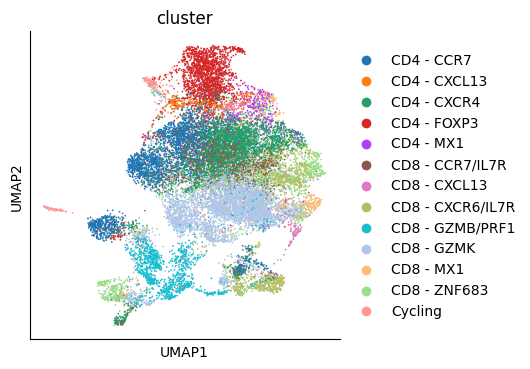

In [ ]:
# visualize clusters
sc.pl.umap(m2_adata_hvg, color='cluster')

In [ ]:
# separate into cd4 and cd8 - use the original adata with counts
m2_adata_cd4 = m2_adata[m2_adata.obs['cluster'].str.startswith('CD4'), :].copy()
m2_adata_cd8 = m2_adata[m2_adata.obs['cluster'].str.startswith('CD8'), :].copy()

# MDA2 CD4 pseudotime and trajectory inference

/Users/hsinyenhuang/Documents/genomics_project/.venv/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/opt/homebrew/Cellar/python@3.13/3.13.9_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


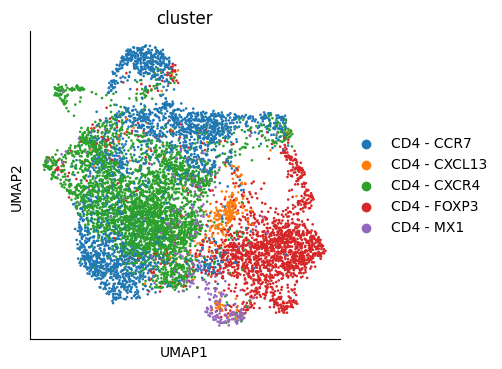

In [ ]:
# preprocess cd4 data from scratch
m2_adata_cd4.layers["counts"] = m2_adata_cd4.X.copy()
sc.pp.normalize_total(m2_adata_cd4, target_sum=1e4)
sc.pp.log1p(m2_adata_cd4)
sc.pp.highly_variable_genes(m2_adata_cd4, n_top_genes=2000, flavor="seurat_v3", layer="counts")
m2_adata_cd4 = m2_adata_cd4[:, m2_adata_cd4.var['highly_variable']].copy()
sc.pp.scale(m2_adata_cd4, max_value=10)
sc.tl.pca(m2_adata_cd4, n_comps=50, svd_solver="arpack")
sc.pp.neighbors(m2_adata_cd4, n_neighbors=15, n_pcs=30, random_state=rng)
sc.tl.umap(m2_adata_cd4, random_state=rng)
sc.pl.umap(m2_adata_cd4, color='cluster')

In [ ]:
# calculate diffusion maps, multiscale space, and magic imputation for mda2 cd4 data
dm_res = palantir.utils.run_diffusion_maps(m2_adata_cd4, n_components=50)
ms_data = palantir.utils.determine_multiscale_space(m2_adata_cd4)
imputed_X = palantir.utils.run_magic_imputation(m2_adata_cd4)

In [ ]:
# Find cell with CCR7 expression near upper quartile
naive = m2_adata_cd4[m2_adata_cd4.obs['cluster'] == 'CD4 - CCR7']
ccr7_expr = naive[:, 'CCR7'].X.toarray().flatten()
q75 = np.percentile(ccr7_expr, 75)

# Find cell closest to 75th percentile (to avoid outliers)
target_value = q75
closest_idx = np.argmin(np.abs(ccr7_expr - target_value))
root_cell = naive.obs_names[closest_idx]

print(f"Selected root cell: {root_cell}")
print(f"Root cell cluster: {m2_adata_cd4.obs.loc[root_cell, 'cluster']}")
print(f"Root cell CCR7 expression: {ccr7_expr[closest_idx]:.3f}")

Selected root cell: MDA2_T03_CTGATAGTCGTTTGCC
Root cell cluster: CD4 - CCR7
Root cell CCR7 expression: 1.583


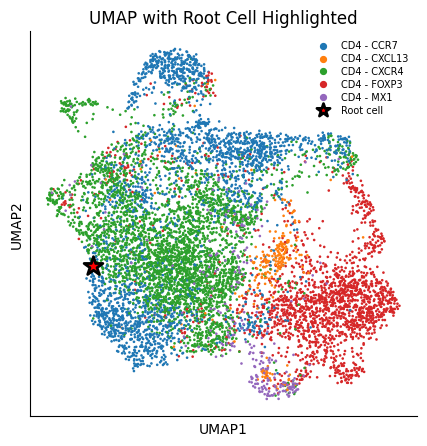

In [ ]:
# plot umap with root cell highlighted
fig, ax = plt.subplots(figsize=(5, 5))

sc.pl.umap(m2_adata_cd4, color=['cluster'],ax=ax, show=False, cmap='viridis')

umap_coords = m2_adata_cd4.obsm['X_umap']

root_idx = m2_adata_cd4.obs.index.get_loc(root_cell)
root_x, root_y = umap_coords[root_idx]

ax.scatter(root_x, root_y, c='red', s=200, marker='*', edgecolors='black', linewidths=2, 
           label=f'Root cell', zorder=10)

ax.legend(loc="best", fontsize=7, markerscale=0.7, frameon=False, labelspacing=0.3)

ax.set_title('UMAP with Root Cell Highlighted')
plt.show()

In [ ]:
# Get unique clusters excluding CD4 - CCR7
clusters_to_find = m2_adata_cd4.obs['cluster'][m2_adata_cd4.obs['cluster'] != 'CD4 - CCR7'].unique()

# Find terminal states for each cluster
terminal_cells = palantir.utils.find_terminal_states(
    m2_adata_cd4, 
    celltypes=clusters_to_find,
    celltype_column='cluster'
)

Using MDA2_T03_CTACGTCGTACTCAAC for cell type CD4 - FOXP3 which is max in diffusion component 2.
Using MDA2_T16_GGAGCAAGTCTGATCA for cell type CD4 - CXCR4 which is min in diffusion component 1.


/Users/hsinyenhuang/Documents/genomics_project/.venv/lib/python3.13/site-packages/palantir/utils.py:1045: UserWarning: No valid component found: CD4 - CXCL13 Consider increasing the number of diffusion components ('n_components' in palantir.utils.run_diffusion_maps). The cell type CD4 - CXCL13 will be skipped.
  warn(
/Users/hsinyenhuang/Documents/genomics_project/.venv/lib/python3.13/site-packages/palantir/utils.py:1045: UserWarning: No valid component found: CD4 - MX1 Consider increasing the number of diffusion components ('n_components' in palantir.utils.run_diffusion_maps). The cell type CD4 - MX1 will be skipped.
  warn(


In [ ]:
# manually specify medoid cell as terminal states for clusters where terminal states could not be identified using diffusion maps
diff_key = "DM_EigenVectors"
k = 30  # number of components to use

for cluster_name in ["CD4 - CXCL13", "CD4 - MX1"]:
    sub = m2_adata_cd4[m2_adata_cd4.obs["cluster"] == cluster_name].copy()

    X = sub.obsm[diff_key][:, :k]
    centroid = X.mean(axis=0)

    d2 = ((X - centroid) ** 2).sum(axis=1)

    medoid_idx = int(np.argmin(d2))
    medoid_cell = sub.obs_names[medoid_idx]

    print("\n---", cluster_name, "---")
    print("Medoid cell:", medoid_cell)



--- CD4 - CXCL13 ---
Medoid cell: MDA2_T06_GGACATTCATATGAGA

--- CD4 - MX1 ---
Medoid cell: MDA2_T25_GTATCTTAGCAATCTC


In [ ]:
# add medoid cells to terminal state pd.Series
cxcl13_medoid = "MDA2_T06_GGACATTCATATGAGA"
mx1_medoid    = "MDA2_T25_GTATCTTAGCAATCTC"

terminal_cells.loc[cxcl13_medoid] = "CD4 - CXCL13"
terminal_cells.loc[mx1_medoid]    = "CD4 - MX1"

print(terminal_cells)


MDA2_T03_CTACGTCGTACTCAAC     CD4 - FOXP3
MDA2_T16_GGAGCAAGTCTGATCA     CD4 - CXCR4
MDA2_T06_GGACATTCATATGAGA    CD4 - CXCL13
MDA2_T25_GTATCTTAGCAATCTC       CD4 - MX1
dtype: object


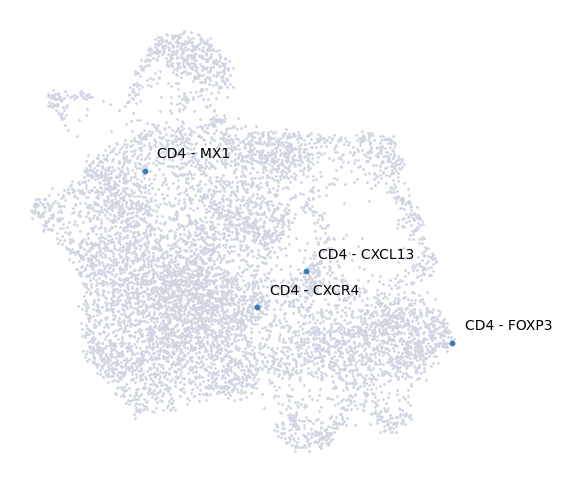

In [ ]:
# plot umap with terminal cells highlighted
palantir.plot.highlight_cells_on_umap(m2_adata_cd4, terminal_cells)
plt.show()

In [ ]:
# run palantir
pr_res = palantir.core.run_palantir(
    m2_adata_cd4, root_cell, num_waypoints=500, terminal_states=terminal_cells
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0012651324272155763 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.054507001241048174 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9995
Correlation at iteration 2: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


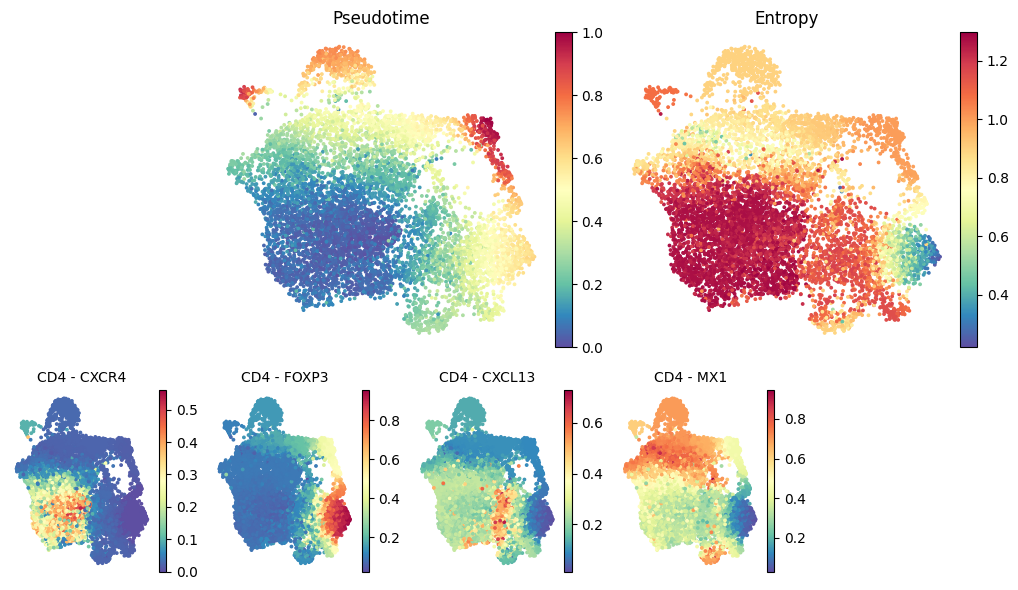

In [ ]:
# plot palantir results
palantir.plot.plot_palantir_results(m2_adata_cd4, s=3)
plt.show()

In [ ]:
# select for cells belonging to specific branches
masks = palantir.presults.select_branch_cells(m2_adata_cd4, q=.01, eps=.01)

<Axes: title={'center': 'palantir_pseudotime'}, xlabel='UMAP1', ylabel='UMAP2'>

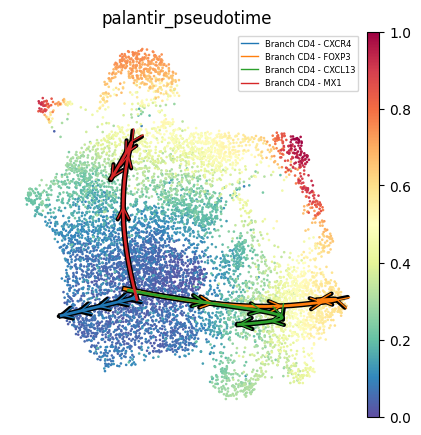

In [ ]:
# plot trajectories
palantir.plot.plot_trajectories(m2_adata_cd4, pseudotime_interval=(0, 1.0), legend_kwargs=dict(fontsize=6))

<Axes: >

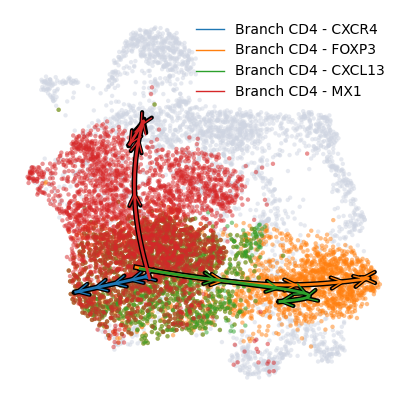

In [ ]:
# trajectories colored by cells belonging to specific branches
palantir.plot.plot_trajectories(m2_adata_cd4, cell_color = "branch_selection", pseudotime_interval=(0, .9))

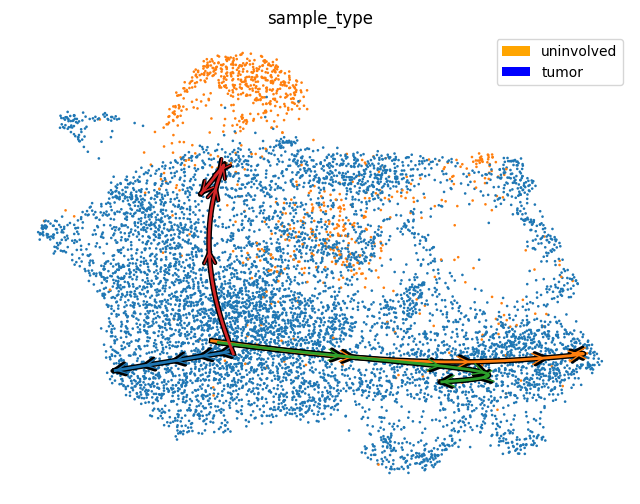

In [ ]:
# umap and trajectories colored by sample type
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(8, 6))
palantir.plot.plot_trajectories(m2_adata_cd4, cell_color="sample_type", pseudotime_interval=(0, .9), ax=ax)

handles, labels = ax.get_legend_handles_labels()

branch_handles = [(h, l) for h, l in zip(handles, labels) if l.startswith('Branch')]

sample_type_handles = [
    (Patch(facecolor='orange'), 'uninvolved'),
    (Patch(facecolor='blue'), 'tumor')
]

all_items = branch_handles + sample_type_handles
all_handles = [h for h, l in all_items]
all_labels = [l for h, l in all_items]

ax.legend(all_handles, all_labels, loc='best')
plt.show()

# MDA2 CD8 pseudotime and trajectory inference

/Users/hsinyenhuang/Documents/genomics_project/.venv/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/opt/homebrew/Cellar/python@3.13/3.13.9_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


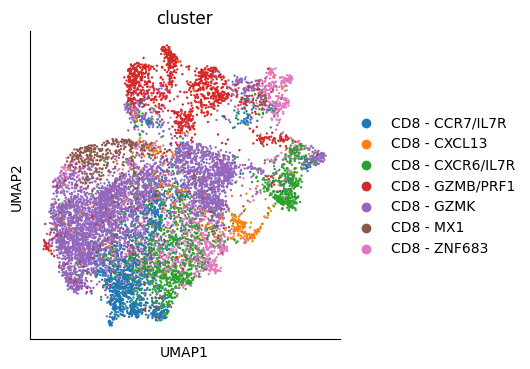

In [ ]:
# preprocess cd8 data from scratch
m2_adata_cd8.layers["counts"] = m2_adata_cd8.X.copy()
sc.pp.normalize_total(m2_adata_cd8, target_sum=1e4)
sc.pp.log1p(m2_adata_cd8)
sc.pp.highly_variable_genes(m2_adata_cd8, n_top_genes=2000, flavor="seurat_v3", layer="counts")
m2_adata_cd8 = m2_adata_cd8[:, m2_adata_cd8.var['highly_variable']].copy()
sc.pp.scale(m2_adata_cd8, max_value=10)
sc.tl.pca(m2_adata_cd8, n_comps=50, svd_solver="arpack")
sc.pp.neighbors(m2_adata_cd8, n_neighbors=15, n_pcs=30, random_state=rng)
sc.tl.umap(m2_adata_cd8, random_state=rng)
sc.pl.umap(m2_adata_cd8, color='cluster')

In [ ]:
# calculate diffusion maps, multiscale space, and magic imputation for mda2 cd8 data
dm_res = palantir.utils.run_diffusion_maps(m2_adata_cd8, n_components=50)
ms_data = palantir.utils.determine_multiscale_space(m2_adata_cd8)
imputed_X = palantir.utils.run_magic_imputation(m2_adata_cd8)

In [ ]:
# Find cell with CCR7/IL7R expression near upper quartile
naive = m2_adata_cd8[m2_adata_cd8.obs['cluster'] == 'CD8 - CCR7/IL7R']
ccr7_expr = naive[:, 'CCR7'].X.toarray().flatten()
q75 = np.percentile(ccr7_expr, 75)

# Find cell closest to 75th percentile (to avoid outliers)
target_value = q75
closest_idx = np.argmin(np.abs(ccr7_expr - target_value))
root_cell = naive.obs_names[closest_idx]

print(f"Selected root cell: {root_cell}")
print(f"Root cell cluster: {m2_adata_cd8.obs.loc[root_cell, 'cluster']}")
print(f"Root cell CCR7 expression: {ccr7_expr[closest_idx]:.3f}")

Selected root cell: MDA2_T19_GGGTCTGGTTCCAACA
Root cell cluster: CD8 - CCR7/IL7R
Root cell CCR7 expression: 2.560


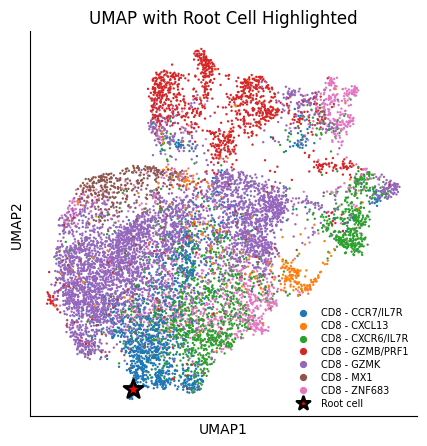

In [ ]:
# plot umap with root cell highlighted
fig, ax = plt.subplots(figsize=(5, 5))

sc.pl.umap(m2_adata_cd8, color=['cluster'],ax=ax, show=False, cmap='viridis')

umap_coords = m2_adata_cd8.obsm['X_umap']

root_idx = m2_adata_cd8.obs.index.get_loc(root_cell)
root_x, root_y = umap_coords[root_idx]

ax.scatter(root_x, root_y, c='red', s=200, marker='*', edgecolors='black', linewidths=2, 
           label=f'Root cell', zorder=10)

ax.legend(loc="best", fontsize=7, markerscale=0.7, frameon=False, labelspacing=0.3)

ax.set_title('UMAP with Root Cell Highlighted')
plt.show()

In [ ]:
# Get unique clusters excluding CD8 - CCR7/IL7R
clusters_to_find = m2_adata_cd8.obs['cluster'][m2_adata_cd8.obs['cluster'] != 'CD8 - CCR7/IL7R'].unique()

# Find terminal states for each cluster
terminal_cells = palantir.utils.find_terminal_states(
    m2_adata_cd8, 
    celltypes=clusters_to_find,
    celltype_column='cluster'
)

Using MDA2_T03_CGAGCCATCGGTGTTA for cell type CD8 - ZNF683 which is min in diffusion component 2.
Using MDA2_U15_GACGGCTAGTTTCCTT for cell type CD8 - CXCR6/IL7R which is min in diffusion component 0.
Using MDA2_T10_CGCCAAGGTAGCTCCG for cell type CD8 - GZMK which is max in diffusion component 0.
Using MDA2_U18_GGCCGATGTTTACTCT for cell type CD8 - GZMB/PRF1 which is max in diffusion component 1.


/Users/hsinyenhuang/Documents/genomics_project/.venv/lib/python3.13/site-packages/palantir/utils.py:1045: UserWarning: No valid component found: CD8 - CXCL13 Consider increasing the number of diffusion components ('n_components' in palantir.utils.run_diffusion_maps). The cell type CD8 - CXCL13 will be skipped.
  warn(
/Users/hsinyenhuang/Documents/genomics_project/.venv/lib/python3.13/site-packages/palantir/utils.py:1045: UserWarning: No valid component found: CD8 - MX1 Consider increasing the number of diffusion components ('n_components' in palantir.utils.run_diffusion_maps). The cell type CD8 - MX1 will be skipped.
  warn(


In [ ]:
# manually specify medoid cell as terminal states for clusters where terminal states could not be identified using diffusion maps
diff_key = "DM_EigenVectors"
k = 30  # number of components to use

for cluster_name in ["CD8 - CXCL13", "CD8 - MX1"]:
    sub = m2_adata_cd8[m2_adata_cd8.obs["cluster"] == cluster_name].copy()

    X = sub.obsm[diff_key][:, :k]
    centroid = X.mean(axis=0)
    d2 = ((X - centroid) ** 2).sum(axis=1)

    medoid_idx = int(np.argmin(d2))
    medoid_cell = sub.obs_names[medoid_idx]

    print("\n---", cluster_name, "---")
    print("Medoid cell:", medoid_cell)


--- CD8 - CXCL13 ---
Medoid cell: MDA2_T01_GCACTCTCAGCATGAG

--- CD8 - MX1 ---
Medoid cell: MDA2_T07_TCGCGAGCAGCGTAAG


In [ ]:
# add medoid cells to terminal state pd.Series
cxcl13_medoid = "MDA2_T01_GCACTCTCAGCATGAG"
mx1_medoid    = "MDA2_T07_TCGCGAGCAGCGTAAG"

terminal_cells.loc[cxcl13_medoid] = "CD8 - CXCL13"
terminal_cells.loc[mx1_medoid]    = "CD8 - MX1"

print(terminal_cells)

MDA2_T03_CGAGCCATCGGTGTTA        CD8 - ZNF683
MDA2_U15_GACGGCTAGTTTCCTT    CD8 - CXCR6/IL7R
MDA2_T10_CGCCAAGGTAGCTCCG          CD8 - GZMK
MDA2_U18_GGCCGATGTTTACTCT     CD8 - GZMB/PRF1
MDA2_T01_GCACTCTCAGCATGAG        CD8 - CXCL13
MDA2_T07_TCGCGAGCAGCGTAAG           CD8 - MX1
dtype: object


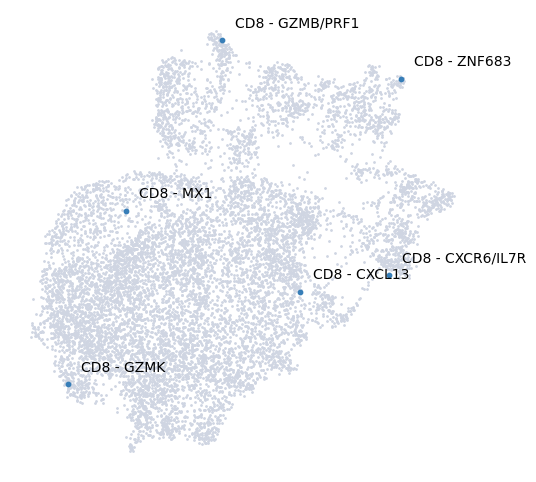

In [ ]:
# plot umap with terminal cells highlighted
palantir.plot.highlight_cells_on_umap(m2_adata_cd8, terminal_cells)
plt.show()

In [ ]:
# run palantir
pr_res = palantir.core.run_palantir(
    m2_adata_cd8, root_cell, num_waypoints=500, terminal_states=terminal_cells
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0016303340593973796 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.06526368459065755 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


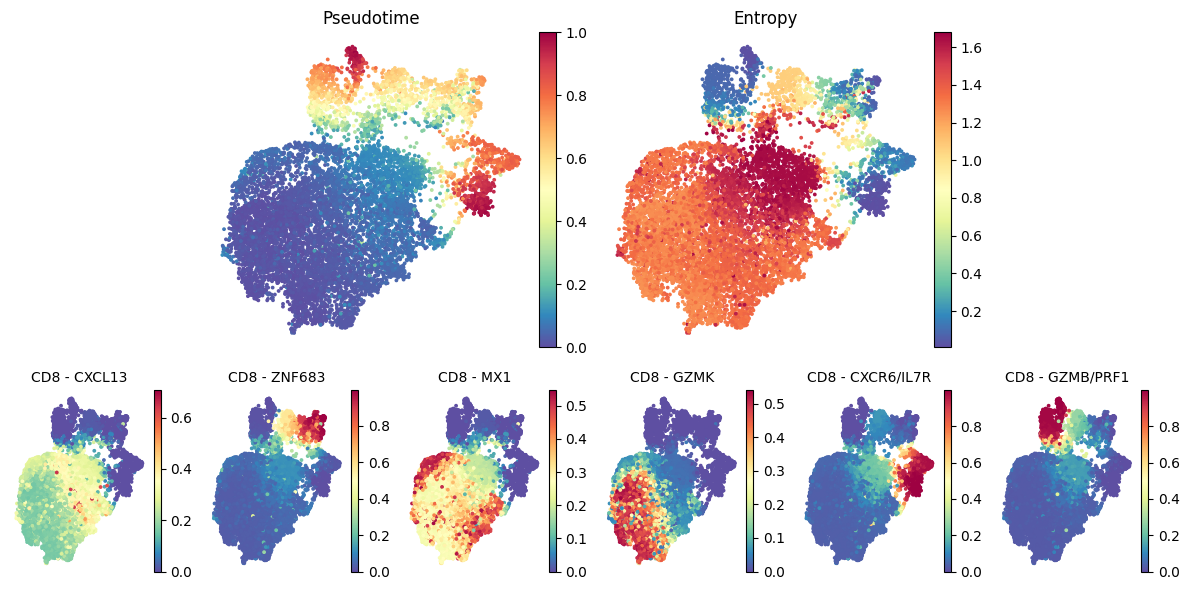

In [ ]:
# plot palantir results
palantir.plot.plot_palantir_results(m2_adata_cd8, s=3)
plt.show()

In [ ]:
# select for cells belonging to specific branches
masks = palantir.presults.select_branch_cells(m2_adata_cd8, q=.01, eps=.01)

<Axes: title={'center': 'palantir_pseudotime'}, xlabel='UMAP1', ylabel='UMAP2'>

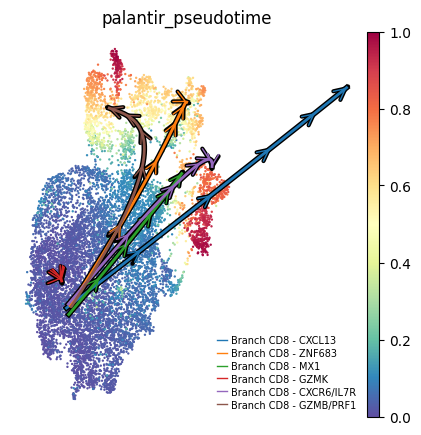

In [ ]:
# plot trajectories
palantir.plot.plot_trajectories(m2_adata_cd8, pseudotime_interval=(0, 0.5),     legend_kwargs=dict(
        fontsize=7,
        frameon=False,
        handlelength=1.0,
        labelspacing=0.3,
        handletextpad=0.4,
        borderpad=0.2,
        loc="lower right",          # pick a corner
        bbox_to_anchor=(1.0, 0.0),  # nudge if needed
    ))

<Axes: >

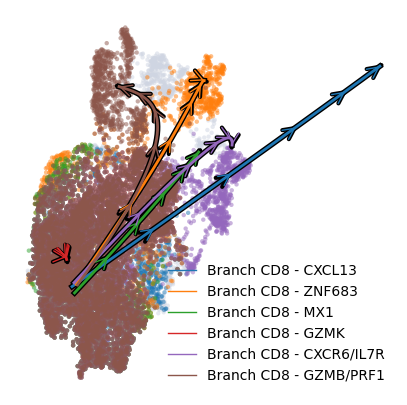

In [ ]:
# trajectories colored by cells belonging to specific branches
palantir.plot.plot_trajectories(m2_adata_cd8, cell_color = "branch_selection", pseudotime_interval=(0, .5))

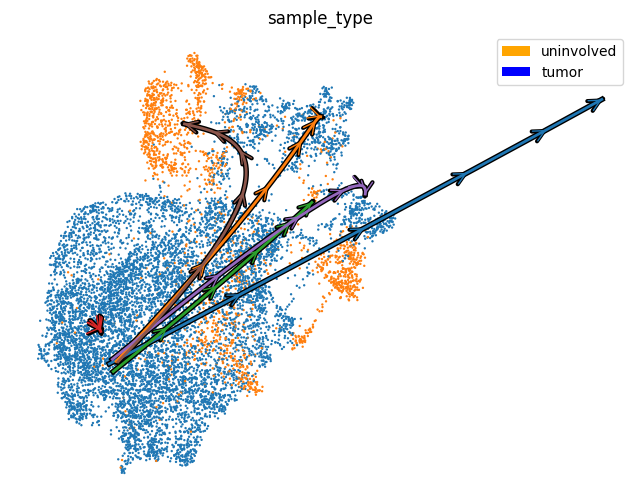

In [ ]:
# umap and trajectories colored by sample type
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(8, 6))
palantir.plot.plot_trajectories(m2_adata_cd8, cell_color="sample_type", pseudotime_interval=(0, .5), ax=ax)

handles, labels = ax.get_legend_handles_labels()

branch_handles = [(h, l) for h, l in zip(handles, labels) if l.startswith('Branch')]

sample_type_handles = [
    (Patch(facecolor='orange'), 'uninvolved'),
    (Patch(facecolor='blue'), 'tumor')
]

all_items = branch_handles + sample_type_handles
all_handles = [h for h, l in all_items]
all_labels = [l for h, l in all_items]

ax.legend(all_handles, all_labels, loc='best')
plt.show()